In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.interpolate import interp1d
from scipy.optimize import minimize

In [2]:
# Step 1: Given Data (Strike, Bid, Ask, x, IV)
data =  np.array([
    [30000,  15.0, 25.0, 139.68, -0.00027],
    [40000,  0.0, 40.0, np.nan, -0.00216],
    [45000,  35.0, 50.0, 101.45, -0.00367],
    [50000,  25.0, 70.0, 85.02, -0.00575],
    [55000,  50.0, 80.0, 79.61, -0.00862],
    [60000,  100.0, 115.0, 74.91, -0.01359],
    [65000,  145.0, 160.0, 67.21, -0.02067],
    [70000,  230.0, 235.0, 60.71, -0.03293],
    [75000,  380.0, 400.0, 54.80, -0.05569],
    [80000,  700.0, 720.0, 50.45, -0.09871],
    [85000,  1360.0, 1375.0, 47.53, -0.17731],
    [88000,  2020.0, 2050.0, 46.42, -0.24491],
    [90000,  2620.0, 2670.0, 46.09, -0.29844],
    [92000,  3350.0, 3400.0, 45.91, -0.35652],
    [94000,  4225.0, 4280.0, 45.95, -0.41741]
])

strikes_given = data[:, 0]
bid_given = data[:, 1]
ask_given = data[:, 2]
iv_given = data[:, 3]


In [3]:
# Step 2: Handle Missing Values with Linear Interpolation
nan_mask = np.isnan(iv_given)
interp_linear = interp1d(strikes_given[~nan_mask], iv_given[~nan_mask], kind='linear', fill_value="extrapolate")
iv_given[nan_mask] = interp_linear(strikes_given[nan_mask])  # Replace NaNs


In [4]:
# Step 3: Generate 4096 Discrete Points & Interpolate IV Using Cubic Spline
strikes_dense = np.linspace(min(strikes_given), max(strikes_given), 4096)
interp_cubic = interp1d(strikes_given, iv_given, kind='cubic')
iv_dense = interp_cubic(strikes_dense)

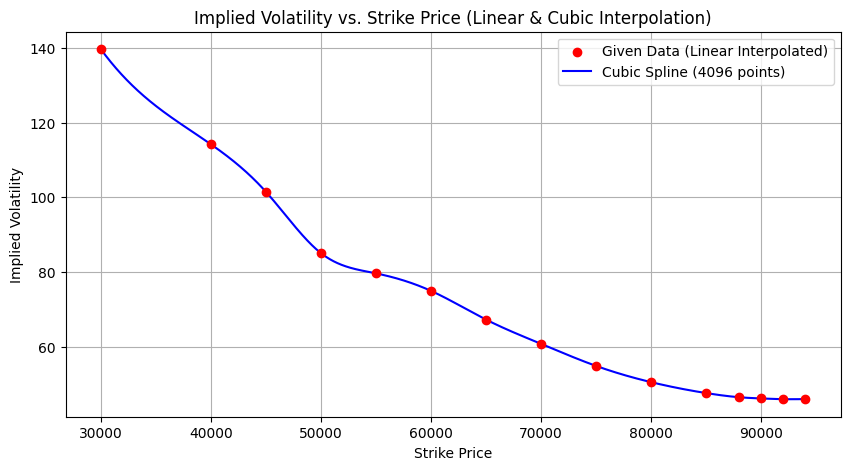

In [5]:
# Step 4: Plot IV vs. Strike Price
plt.figure(figsize=(10, 5))
plt.scatter(strikes_given, iv_given, color='red', label="Given Data (Linear Interpolated)", zorder=3)
plt.plot(strikes_dense, iv_dense, 'b-', label="Cubic Spline (4096 points)", zorder=2)

# Formatting
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility vs. Strike Price (Linear & Cubic Interpolation)")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Filter out strike prices and IV values where strike price is below 55,000
strike_limit = 55000
mask = strikes_dense <= strike_limit
strikes_filtered = strikes_dense[mask]
iv_filtered = iv_dense[mask]


In [7]:
def heston_jump_cf(u, S0, T, r, v0, kappa, theta, sigma, rho, lambd, mu_J, sigma_J):
    """
    Characteristic function for Heston model with jumps.
    u: Fourier transform variable
    S0: Initial asset price
    T: Time to maturity
    r: Risk-free rate
    v0: Initial volatility
    kappa: Mean reversion speed
    theta: Long-term volatility
    sigma: Volatility of volatility
    rho: Correlation between asset and volatility
    lambd: Jump intensity
    mu_J: Mean jump size
    sigma_J: Jump volatility
    """
    # Calculate the complex variable
    lambda_term = kappa - sigma**2 / 2
    d = np.sqrt((rho * sigma * u * 1j - lambda_term)**2 + u**2 * (sigma**2 + 1j * 2 * rho * sigma * u))
    g1 = (lambda_term - rho * sigma * u * 1j - d) / (lambda_term - rho * sigma * u * 1j + d)
    
    # Calculate the jumps component
    jump_term = lambd * T * (1 / (1 - 1j * u * mu_J) - 1)
    
    # Return the characteristic function
    return np.exp(1j * u * np.log(S0) + (r - 0.5 * v0) * u * T + (np.sqrt(v0) * u * T) - (kappa * theta * T * (u**2) / (2 * np.pi)))



In [8]:
def price_option_fft(S0, K, T, r, strikes, v0, kappa, theta, sigma, rho, lambd, mu_J, sigma_J):
    """
    Prices an option using the Heston model with jumps via FFT.
    S0: Initial stock price
    K: Strike price
    T: Time to maturity
    r: Risk-free rate
    strikes: Array of strike prices
    v0, kappa, theta, sigma, rho, lambd, mu_J, sigma_J: Model parameters
    """
    # Define FFT parameters
    N = len(strikes)
    dS = strikes[1] - strikes[0]  # Strike spacing
    alpha = 1.5  # Typically used for option pricing via FFT
    u = np.linspace(0, N-1, N)
    
    # Compute the characteristic function for each u
    phi_u = np.array([heston_jump_cf(u_val, S0, T, r, v0, kappa, theta, sigma, rho, lambd, mu_J, sigma_J) for u_val in u])
    
    # Compute the FFT of the characteristic function
    fft_prices = np.fft.ifft(phi_u)
    
    # Compute the option price based on FFT and integrate it
    option_prices = np.real(np.fft.ifft(np.exp(-1j * u * np.log(strikes)) * fft_prices))
    
    return option_prices


In [10]:
from scipy.optimize import minimize

def objective_function_fft(params, strikes, iv_market, S0, T, r):
    """
    Objective function to minimize the difference between model's implied volatilities
    and the market implied volatilities using FFT pricing.
    """
    v0, kappa, theta, sigma, rho, lambd, mu_J, sigma_J = params
    iv_model = price_option_fft(S0, strikes, T, r, strikes, v0, kappa, theta, sigma, rho, lambd, mu_J, sigma_J)
    
    # Calculate the squared difference between model and market implied volatilities
    error = np.sum((iv_model - iv_market)**2)
    return error

# Calibration with initial guesses
initial_guess = [0.04, 1.0, 0.04, 0.2, -0.5, 0.1, 0.05, 0.1]
S0 = 95000
T = round(28/252,2)
r = 4.5
calibration_result = minimize(objective_function_fft, initial_guess, args=(strikes_filtered, iv_filtered, S0, T, r))

# Get the calibrated parameters
calibrated_params = calibration_result.x


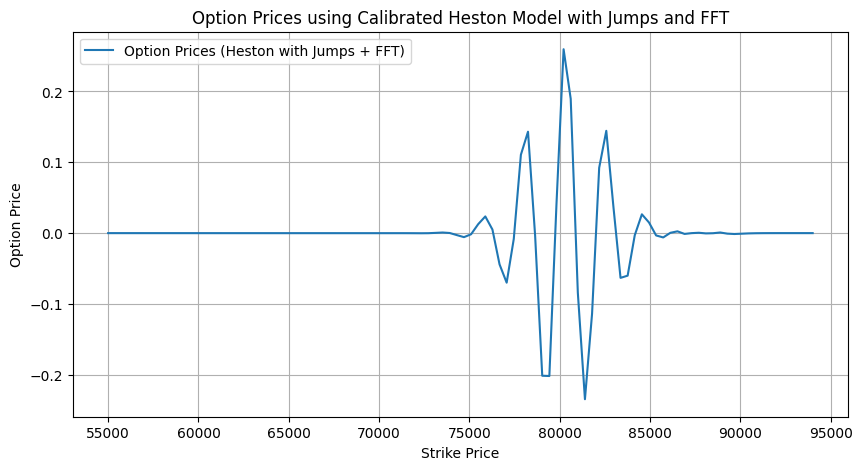

In [11]:
# Price options for a range of strikes
strike_range = np.linspace(55000, 94000, 100)
option_prices = price_option_fft(S0, strike_range, T, r, strike_range, *calibrated_params)

# Plot the option prices
plt.figure(figsize=(10, 5))
plt.plot(strike_range, option_prices, label="Option Prices (Heston with Jumps + FFT)")
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title("Option Prices using Calibrated Heston Model with Jumps and FFT")
plt.grid(True)
plt.legend()
plt.show()
